In [1]:
!pip install transformers
!pip install sentence_transformers

In [2]:
pip install Cython

#Preprocessing Data

In [3]:
#Importing the libraries needed
import pickle
import numpy as np

import gensim
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Importing the data
with open('train_qa.txt','rb') as f:
    train_data=pickle.load(f)
with open("test_qa.txt",'rb') as f:
  test_data = pickle.load(f)

In [5]:
#Combining the data
data = train_data + test_data




In [6]:
from sentence_transformers import SentenceTransformer

In [7]:
#Performing some preprocessing tasks
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
          self.word2vec = word2vec
          self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
            return self
    def transform(self, X):
            return np.array([
                np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                        or [np.zeros(self.dim)], axis=0)
                for words in X
            ])
def w2v(X_train, X_test):
  model = gensim.models.Word2Vec([doc for i, doc in enumerate(X_train+X_test)], min_count = 1, 
                              size = 100, window = 5)

  scaler = MinMaxScaler()


  d2v = dict(zip(model.wv.index2word, model.wv.syn0)) 
  modelw = EmbeddingVectorizer(d2v)
  # converting text to numerical data using Word2Vec 
  X_train_vectors_w2v = modelw.transform(X_train)
  X_train_vec = scaler.fit_transform(X_train_vectors_w2v)#Used for normalising the vector

  X_test_vectors_w2v = modelw.transform(X_test)
  X_test_vec = scaler.fit_transform(X_test_vectors_w2v)#Used for normalising the vector
  return [X_train_vec,X_test_vec]

  

In [9]:
# Dividing the data as story,question and answer
train_story_text=[]
train_question_text=[]
train_answers=[]

for story,question,answer in data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)


In [10]:
# Concatenating the story and question pairs
sq_pairs = [str(train_story_text[i])+" "+str(train_question_text[i]) for i in range(len(train_story_text))]

In [11]:
import nltk

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
word = []
for statement in sq_pairs:
  stop = set(stopwords.words('english') + list(string.punctuation))
  st = word_tokenize(statement)
  lemmatizer = WordNetLemmatizer()
  finalStats =[]
  for x in st:
    if x not in stop:
      finalStats.append(lemmatizer.lemmatize(x))
  word.append(finalStats)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Baseline Features

In [15]:
word[0:5]

[["'Mary",
  "'moved",
  "'to",
  "'the",
  "'bathroom",
  "'Sandra",
  "'journeyed",
  "'to",
  "'the",
  "'bedroom",
  "'Is",
  "'Sandra",
  "'in",
  "'the",
  "'hallway"],
 ["'Mary",
  "'moved",
  "'to",
  "'the",
  "'bathroom",
  "'Sandra",
  "'journeyed",
  "'to",
  "'the",
  "'bedroom",
  "'Mary",
  "'went",
  "'back",
  "'to",
  "'the",
  "'bedroom",
  "'Daniel",
  "'went",
  "'back",
  "'to",
  "'the",
  "'hallway",
  "'Is",
  "'Daniel",
  "'in",
  "'the",
  "'bathroom"],
 ["'Mary",
  "'moved",
  "'to",
  "'the",
  "'bathroom",
  "'Sandra",
  "'journeyed",
  "'to",
  "'the",
  "'bedroom",
  "'Mary",
  "'went",
  "'back",
  "'to",
  "'the",
  "'bedroom",
  "'Daniel",
  "'went",
  "'back",
  "'to",
  "'the",
  "'hallway",
  "'Sandra",
  "'went",
  "'to",
  "'the",
  "'kitchen",
  "'Daniel",
  "'went",
  "'back",
  "'to",
  "'the",
  "'bathroom",
  "'Is",
  "'Daniel",
  "'in",
  "'the",
  "'office"],
 ["'Mary",
  "'moved",
  "'to",
  "'the",
  "'bathroom",
  "'Sandra",
  "'journey

Splitting the data into train and test data

In [16]:

from sklearn.model_selection import train_test_split
X= word
y=train_answers



In [17]:
from sklearn import preprocessing

In [18]:
le = preprocessing.LabelEncoder()
le.fit(y)

LabelEncoder()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [20]:
X_train,X_test = w2v(X_train=X_train,X_test= X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


In [21]:
#classify response type
from sklearn.svm import SVC
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb
svmmodel = SVC(kernel='sigmoid', gamma="auto", C=10, decision_function_shape='ovo')
clf = make_pipeline(StandardScaler(), svmmodel)
clf.fit(X_train, le.transform(y_train))
predictions = svmmodel.predict(X_test)
accuracy = svmmodel.score(X_test, le.transform(y_test))
f1score = f1_score(le.transform(y_test), predictions, average='micro')
print(classification_report(le.transform(y_test), predictions))


              precision    recall  f1-score   support

           0       0.50      0.65      0.57      1812
           1       0.51      0.37      0.43      1818

    accuracy                           0.51      3630
   macro avg       0.51      0.51      0.50      3630
weighted avg       0.51      0.51      0.50      3630



Visualizing the result

In [22]:
import seaborn as sns
import pandas as pd


In [23]:

from yellowbrick.classifier import ClassificationReport
# Specify the target classes
classes = ["no", "yes"]
clf_report=classification_report(le.transform(y_test), predictions)
visualizer = ClassificationReport(svmmodel,classes=classes, support=True)

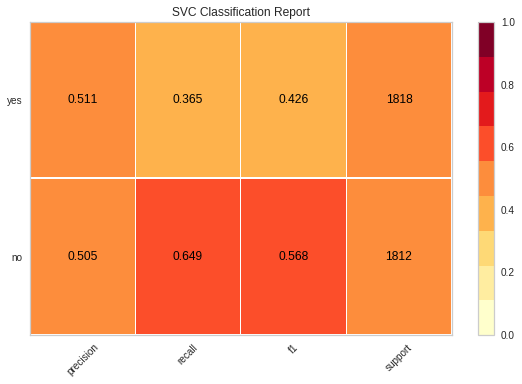

In [24]:
visualizer.fit(X_train, le.transform(y_train))        # Fit the visualizer and the model
visualizer.score(X_test, le.transform(y_test))        # Evaluate the model on the test data
visualizer.show() 

#Test Code


In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
clf = RandomForestClassifier(min_samples_leaf=8, n_estimators=60)
clf = make_pipeline(StandardScaler(), clf)
clf.fit(X_train, le.transform(y_train))
predictions = clf.predict(X_test)
accuracy = clf.score(X_test, le.transform(y_test))
accuracy

0.5104683195592287

In [27]:
model = xgb.XGBClassifier()
param_dist = {"max_depth": [3,5,10],
              "min_child_weight" : [1,5,10],
              "learning_rate": [0.07, 0.1,0.2],
               }

# run randomized search
grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
                                   verbose=5, n_jobs=-1)
grid_search.fit(X_train, le.transform(y_train))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.07, 0.1, 0.2],
                         'max_depth': [3, 5, 10],
                         'min_child_weight': [1, 5, 10]},
             verbose=5)

In [28]:


predictions = grid_search.predict(X_test)
accuracy = grid_search.score(X_test, le.transform(y_test))
accuracy

0.4972451790633609

##Bert Model

In [68]:
all_data=test_data+ train_data

In [69]:
import pandas as pd
import numpy as np
import os
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn import svm
from sentence_transformers import SentenceTransformer
from nltk import pos_tag, word_tokenize
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity

In [70]:
# Baseline
#utility function for BERT word embeddings
def bert_vectorize(sentences):
    #load pretrained BERT model
    model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')
    #encode sentences
    vectors = model.encode(sentences)
    return list(vectors)

In [71]:
#get word embeddings using BERT
vectorized_sq_pairs = bert_vectorize(sq_pairs)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/630 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/409 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [72]:
from sklearn.model_selection import train_test_split
X= vectorized_sq_pairs
y = train_answers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [73]:
#classify response type
svmmodel = SVC(kernel='linear', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
predictions = svmmodel.predict(X_test)
accuracy = svmmodel.score(X_test, y_test)
f1score = f1_score(y_test, predictions, average='micro')
print(classification_report(y_test, predictions))
print("Accuracy of SVM with Polynomial Kernel:", accuracy)

              precision    recall  f1-score   support

          no       0.63      0.61      0.62      1803
         yes       0.63      0.65      0.64      1827

    accuracy                           0.63      3630
   macro avg       0.63      0.63      0.63      3630
weighted avg       0.63      0.63      0.63      3630

Accuracy of SVM with Polynomial Kernel: 0.6297520661157024


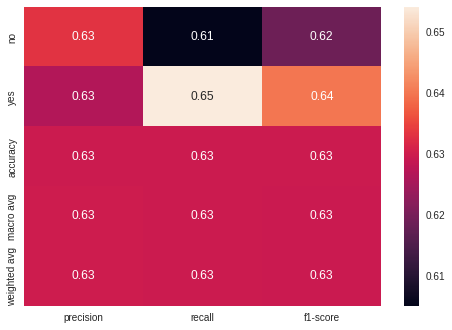

In [74]:
import seaborn as sns
clf_report=classification_report(y_test, predictions,
                                        output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [75]:
from yellowbrick.classifier import ClassificationReport
classes = ["no", "yes"]
clf_report=classification_report(y_test, predictions)
visualizer = ClassificationReport(svmmodel,classes=classes, support=True)

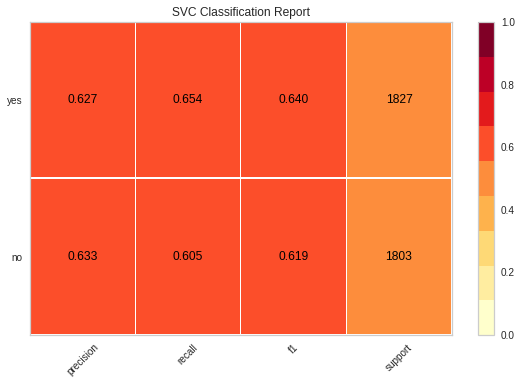

In [76]:
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show() 

##End to End Memory Model

In [77]:
#adding vocabulary in the set
vocab =set()
for story,question,answer in data:
    vocab=vocab.union(set(story))
    vocab=vocab.union(set(question))

In [78]:
vocab.add('no')
vocab.add('yes')

In [79]:
# preview of vocab
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [81]:
vocab_len=len(vocab)+1


In [82]:

#Longest story

all_story_lens=[len(x[0]) for x in data]
max_story_len=max(all_story_lens)

In [83]:
#Longest question
all_question_lens=[len(x[1]) for x in data]
max_question_len=max(all_question_lens)

In [87]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [88]:
# integer encode sequences of words
tokenizer=Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [89]:
train_story_seq =tokenizer.texts_to_sequences(train_story_text)


Functionalize Vectorization

In [90]:
def vectorize_stories(data,word_index=tokenizer.word_index,max_story_len=max_story_len,max_question_len=max_question_len):
    X=[]
    #Questions=Xq
    Xq=[]
    #Y Correct answer(yes/no)
    Y=[]
    
    for story,query,answer in data:
        x=[word_index[word.lower()] for word  in story]
        xq=[word_index[word.lower()] for word in query]
        y=np.zeros(len(word_index)+1)
        y[word_index[answer]]=1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X,maxlen=max_story_len),pad_sequences(Xq,maxlen=max_question_len),np.array(Y))

    '''

    OUTPUT:
    
    Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
    answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
    output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.
    
    Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
'''

In [91]:
inputs_train , queries_train , answers_train =vectorize_stories(train_data)


In [92]:
inputs_test , queries_test , answers_test =vectorize_stories(test_data)


In [93]:
#example of vectorized data
inputs_test

array([[ 0,  0,  0, ..., 32, 10,  7],
       [ 0,  0,  0, ..., 32, 25,  7],
       [ 0,  0,  0, ..., 32, 25,  7],
       ...,
       [ 0,  0,  0, ..., 32, 17,  7],
       [ 0,  0,  0, ..., 32, 25,  7],
       [ 0,  0,  0, ..., 17, 13,  7]], dtype=int32)

Creating Model

In [94]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input, Activation, Dense, Permute, Dropout
from tensorflow.keras.layers import add, dot, concatenate
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop

In [95]:
# we have two inputs stories and questions
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))
#Input() is used to instantiate a Keras tensor.

To build this network we have choosen the below article

Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus, "End-To-End Memory Networks", http://arxiv.org/abs/1503.08895
Encoders

In [96]:
#INPUT ENCODER M
# Input gets embedded to a sequence of vectors
embedding_dim = 128
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_len,output_dim= embedding_dim))
input_encoder_m.add(Dropout(0.3))
# This encoder will output:
# (samples, story_maxlen, embedding_dim)


#INPUT ENCODER C
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_len,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

# output: (samples, story_maxlen, query_maxlen)

#question ENCODER C
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_len,
                               output_dim=embedding_dim,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))


In [97]:
#Encoded<---encoder(input)
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

Use dot product to compute the match between first input vector seq and the query

In [98]:
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [99]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)

In [100]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [101]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)

In [102]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_len)(answer)

In [105]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)
# build the final model
model = Model([input_sequence, question], answer)
optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [106]:
import math
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

initial_learning_rate = 0.01
epochs = 120
decay = initial_learning_rate / epochs

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 20
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

learning_rate = LearningRateScheduler(lr_step_decay, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.66, patience=5, min_lr=0.0001, verbose=1)

In [107]:
#Train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=256,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/120
40/40 [==============================] - 4s 36ms/step - loss: 3.2118 - accuracy: 0.4793 - val_loss: 3.1715 - val_accuracy: 0.5030
Epoch 2/120
40/40 [==============================] - 1s 17ms/step - loss: 3.1781 - accuracy: 0.4939 - val_loss: 3.1710 - val_accuracy: 0.5030
Epoch 3/120
40/40 [==============================] - 1s 16ms/step - loss: 3.1740 - accuracy: 0.4956 - val_loss: 3.1722 - val_accuracy: 0.5030
Epoch 4/120
40/40 [==============================] - 1s 17ms/step - loss: 3.1752 - accuracy: 0.4975 - val_loss: 3.1767 - val_accuracy: 0.4970
Epoch 5/120
40/40 [==============================] - 1s 16ms/step - loss: 3.1730 - accuracy: 0.5034 - val_loss: 3.1741 - val_accuracy: 0.4970
Epoch 6/120
40/40 [==============================] - 1s 16ms/step - loss: 3.1749 - accuracy: 0.4939 - val_loss: 3.1710 - val_accuracy: 0.5030
Epoch 7/120
40/40 [==============================] - 1s 16ms/step - loss: 3.1731 - accuracy: 0.5026 - val_loss: 3.1763 - val_accuracy: 0.4970
Epoch 

In [108]:
#Saving the model
filename = 'chatbot_120_epochs_9710.h5'
model.save(filename)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [124]:
#Predicting the result
model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))


In [125]:
story =' '.join(word for word in test_data[0][0])
print(story)
query = ' '.join(word for word in test_data[0][1])
print(query)


Mary got the milk there . John moved to the bedroom .
Is John in the kitchen ?


In [128]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [131]:
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)


Predicted answer is:  no


In [132]:
history.history['accuracy'][-1]

0.8784000277519226

Plotting Out Training History

In [122]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


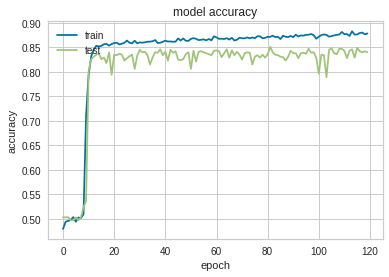

In [123]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Additional feature BERT Model

In [58]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

In [59]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [60]:
def answer_question(question, answer_text):
    input_ids = tokenizer.encode(question, answer_text)
    sep_index = input_ids.index(tokenizer.sep_token_id)
    num_seg_a = sep_index + 1
    num_seg_b = len(input_ids) - num_seg_a
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    assert len(segment_ids) == len(input_ids)
    outputs = model(torch.tensor([input_ids]), 
                    token_type_ids=torch.tensor([segment_ids]),
                    return_dict=True) 

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    answer = tokens[answer_start]
    for i in range(answer_start + 1, answer_end + 1):
      if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
      else:
        answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

In [64]:
import textwrap
import torch

wrapper = textwrap.TextWrapper(width=80) 

bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."

bert_abstract

'We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement)

In [65]:
question = "What does the 'B' in BERT stand for?"

answer_question(question, bert_abstract)

Answer: "bidirectional encoder representations from transformers"


In [66]:
question = "Is BERT simple?"

answer_question(question, bert_abstract)

Answer: "conceptually simple and empirically powerful"


In [67]:
from transformers import pipeline

model_checkpoint = 'bert-large-uncased-whole-word-masking-finetuned-squad' 
qa_pipeline =  pipeline('question-answering', model=model_checkpoint, tokenizer=model_checkpoint)

qa_pipeline(question=["What does the 'B' in BERT stand for?"], context=bert_abstract)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

{'answer': 'Bidirectional Encoder Representations from Transformers',
 'end': 134,
 'score': 0.9618996381759644,
 'start': 79}